# Prioritized DDQN vs Vanilla DDQN with [ReLAx](https://github.com/nslyubaykin/relax)

For ReLAx & Mujoco installation see:
https://github.com/nslyubaykin/relax/blob/master/README.md

Useful readings regarding TD3:
- DQN paper: https://arxiv.org/pdf/1312.5602.pdf
- Double DQN paper: https://arxiv.org/pdf/1509.06461.pdf
- Prioritized Experience Replay paper: https://arxiv.org/pdf/1511.05952.pdf

!Note: For examining trained actor you may just load trained policies from \trained_models directory.
To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/prioritized_ddqn

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.critics import DQN
from relax.rl.actors import ArgmaxQValue

from relax.zoo.critics import AtariQCNN

from relax.schedules import PiecewiseSchedule, LinearSchedule, CombinedSchedule, ConstantSchedule
from relax.exploration import EpsilonGreedy

from relax.gym.utils import get_wrapper_by_name, visualize_actor
from relax.gym.wrappers.atari import *

from relax.data.sampling import Sampler
from relax.data.replay_buffer import ReplayBuffer

/home/nikita/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining ArgmaxQValue actor and DQN critic

For prioritized experience replay benchmarking we will use Double DQN as a base algorithm. We will also use the same setting as in [Double DQN example](https://github.com/nslyubaykin/relax_double_dqn_example/blob/master/double_dqn_tutorial.ipynb) and for brevity of the tutorial detailed Double DQN explanation will be omitted.

# Create prioritized replay buffer

In contrast to uniform replay buffer, prioritized replay buffer samples transitions according to their priority, which is set by the magnitude of TD error. This, in theory, allows to replay important transitions more frequently, and therefore learn more efficiently.

To use prioritization with ReLAx specify a list of `prioritized_learners` (learner that would provide prioritization value and sample according to it). One buffer can be used with several different prioritized learners (and uniform learners as well). Learner itself should support prioritization and have `prioritized_sampling` set to `True`.

!Note: Here we use a proportional variant of PER based on sum tree data structure.

# Benchmarking vanilla DDQN vs prioritized DDQN


!Note: Prioritized replay buffer is supported for all off-policy value based algorithms: DQN and its augmentations, DDPG, TD3 & SAC.

# Define schedules for prioritization

!Note: Prioritized replay introduces bias because it changes this distribution in an uncontrolled fashion, and therefore changes the solution that the estimates will converge to. We can correct this bias by using importance-sampling (IS) weights. We therefore exploit the flexibility of annealing the amount of importance-sampling correction ($ {\beta} $) over time, by defining a schedule on the exponent $ {\beta} $ that reaches 1 only at the end of learning

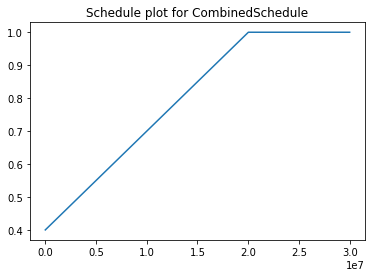

In [2]:
betta_schedule1 = LinearSchedule(0.4, 1, 20000000)
betta_schedule2 = ConstantSchedule(1)
betta_schedule = CombinedSchedule(betta_schedule1, betta_schedule2, min)
betta_schedule.plot(int(3e7))


# Create training and eval environments

On practice, when training DQN on Atari 2600 domain, algorithm is not fed with raw environment observations, instead several wrappers are applied:

1) EpisodicLifeEnv - make end-of-life == end-of-episode, but only reset on true game over. Done by DeepMind for the DQN and co. since it helps value estimation

2) NoopResetEnv - Sample initial states by taking random number of no-ops on reset. No-op is assumed to be action 0.

3) MaxAndSkipEnv - Return only every skip-th frame and do max-pooling over most recent two observations

4) FireResetEnv - Take action on reset for environments that are fixed until firing.

5) ProcessFrame84 - Crop valid region of an observation, convert to grayscale, resize to 84x84. Cast to uint8 dtype for lower memory usage.

6) ClipRewardEnv - Bin reward to {+1, 0, -1} by its sign.


In [2]:
def makeenv(env_name, hcrop, hstretch, seed):
    
    env = gym.make(env_name)
    ob_unwrap = env.reset()
    
    env = gym.wrappers.Monitor(
        env,
        'monitor_train_logs',
        force=True,
        video_callable=None,
    )
    
    env = wrap_deepmind(
        env, 
        skip=4,
        hcrop=hcrop, 
        hstretch=hstretch
    )
    
    env.seed(seed)
    
    ob = env.reset()
    
    return env, ob_unwrap, ob 


In [3]:
env_name = 'NameThisGame-v0'

# Capture game region by adjusting these params:
hcrop=0 # skip n top lines of pixels
hstretch=100 # compression of vertical dimention from 210 -> hstretch (should be > than hcrop+84)

env, ob_unwrap, ob = makeenv(
    env_name=env_name, hcrop=hcrop, 
    hstretch=hstretch, seed=12
)

print(ob_unwrap.shape, ob.shape)

(210, 160, 3) (84, 84, 1)


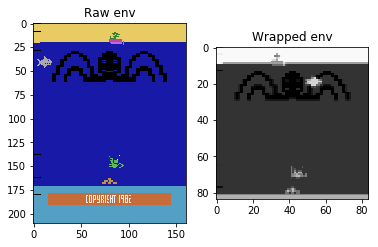

In [4]:
# Visualize raw and wrapped environment:
plt.subplot(1, 2, 1)
plt.imshow(ob_unwrap)
plt.title('Raw env')
plt.subplot(1, 2, 2)
plt.imshow(ob.squeeze(), cmap='gray')
plt.title('Wrapped env')
plt.show()

In [5]:
env.action_space

Discrete(6)

In [6]:
acs_dim = 6
n_experiments = 4
n_steps = 1500000

logdir = '/home/nikita/Desktop/RelaxExamples/Prioritization/tensorboard_logs'
log_every = 10000
logs_by_run = {}

# Performing the Experiment

In [8]:
for exp_i in range(n_experiments):
    
    for prioritization in [False, True]:
        
        prefix = 'prioritized' if prioritization else 'uniform'
        
        # Creating schedules:
        # first 10000 iterations no learning - just data collection
        lr_schedule = PiecewiseSchedule({0: 50000},
                                        2.5*1e-4/4 if prioritization else 2.5*1e-4) 
        
        schedule1 = ConstantSchedule(1)
        schedule2 = LinearSchedule(1.04, 0, 1200000)
        schedule1 = CombinedSchedule(schedule1, schedule2, min)
        schedule2 = LinearSchedule(0.1, 0, 25000000)
        eps_schedule = CombinedSchedule(schedule1, schedule2, max)
        
        betta_schedule1 = LinearSchedule(0.4, 1, 20000000)
        betta_schedule2 = ConstantSchedule(1)
        betta_schedule = CombinedSchedule(betta_schedule1, betta_schedule2, min)
        
        # Crteating environments:
        env, ob_unwrap, ob = makeenv(
            env_name=env_name, hcrop=hcrop, 
            hstretch=hstretch, seed=12
        )
        
        # Exploration
        exploration = EpsilonGreedy(eps=eps_schedule)

        # Actor
        actor = ArgmaxQValue(
                exploration=exploration
        )
        
        # Critic
        critic = DQN(
            critic_net=AtariQCNN(in_channels=4, # 1 current frame + 3 recent lags
                                 acs_dim=acs_dim),
            device=torch.device('cuda'),
            learning_rate=lr_schedule,
            batch_size=32,
            gamma=0.99,
            target_updates_freq=10000,
            n_steps_per_update=1,
            update_freq=4,
            double_q=True, # Double DQN
            prioritized_sampling=prioritization, # Prioritized vs Uniform
            alpha=0.6,
            betta=betta_schedule,
            priority_eps=1e-3,
            obs_nlags=3,
            obs_expand_axis=None,
            obs_concat_axis=-1,
            obs_padding='zeros'
        )
        
        # Provide actor with critic
        actor.set_critic(critic)
        
        # Create replay buffer and wrap envs into Sampler:
        sampler = Sampler(env=env,
                          obs_nlags=3,
                          obs_expand_axis=None,
                          obs_concat_axis=-1,
                          obs_padding='zeros')
        
        if prioritization:
            replay_buffer = ReplayBuffer(
                int(1e6),
                prioritized_learners=[critic] # Prioritized
            ) 
        else:
            replay_buffer = ReplayBuffer(int(1e6))
        
        # Run Training Loop
        run_name = f'{prefix}_ddqn_{env_name}_experiment_{exp_i}'
        logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
        all_logs = []
        
        print(f'Running: {run_name}')

        for step in tqdm(range(n_steps)): 

            # sample training batch
            unit_pathlist = sampler.sample(actor=actor,
                                           n_transitions=1,
                                           max_path_length=None, 
                                           reset_when_not_done=False,
                                           train_sampling=True)

            # add transitions to replay buffer
            replay_buffer.add_paths(unit_pathlist)

            # update critic
            critic_logs = critic.update(replay_buffer)

            # update actor
            actor_logs = actor.update(replay_buffer)

            if step % log_every == 0 and step > 0:

                # create logs of buffer
                buffer_logs = replay_buffer.create_logs(prefix='buffer')

                # add unwrapped reward logs
                mean_unwr_train = np.mean(get_wrapper_by_name(env, 'Monitor').get_episode_rewards()[-20:])
                unwr_rews = {'average_train_unwr_rews': mean_unwr_train}
                
                logs = {**critic_logs,
                        **actor_logs,
                        **buffer_logs,
                        **unwr_rews}
                all_logs.append(logs)

                for key, value in logs.items():
                    logger.add_scalar(key, value, step)

        logger.flush()
        
        # Saving run's logs
        logs_by_run[run_name] = all_logs
        
        # Saving models:
        actor.save_checkpoint(f'trained_models/{prefix}_ddqn', run_name+'_actor')
        critic.save_checkpoint(f'trained_models/{prefix}_ddqn', run_name+'_critic')

Running: uniform_ddqn_NameThisGame-v0_experiment_0


100%|██████████| 1500000/1500000 [2:50:26<00:00, 146.68it/s]  
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for ArgmaxQValue...
exploration_global_step global_step
Saved checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler
Running: prioritized_ddqn_NameThisGame-v0_experiment_0


100%|██████████| 1500000/1500000 [3:04:34<00:00, 135.44it/s]  
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for ArgmaxQValue...
exploration_global_step global_step
Saved checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler
Running: uniform_ddqn_NameThisGame-v0_experiment_1


100%|██████████| 1500000/1500000 [2:56:13<00:00, 141.87it/s]  
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for ArgmaxQValue...
exploration_global_step global_step
Saved checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler
Running: prioritized_ddqn_NameThisGame-v0_experiment_1


100%|██████████| 1500000/1500000 [3:13:05<00:00, 129.47it/s]  
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for ArgmaxQValue...
exploration_global_step global_step
Saved checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler
Running: uniform_ddqn_NameThisGame-v0_experiment_2


100%|██████████| 1500000/1500000 [3:06:14<00:00, 134.23it/s]  
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for ArgmaxQValue...
exploration_global_step global_step
Saved checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler
Running: prioritized_ddqn_NameThisGame-v0_experiment_2


100%|██████████| 1500000/1500000 [3:08:16<00:00, 132.78it/s]  
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for ArgmaxQValue...
exploration_global_step global_step
Saved checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler
Running: uniform_ddqn_NameThisGame-v0_experiment_3


100%|██████████| 1500000/1500000 [2:51:19<00:00, 145.92it/s]  
/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved checkpoints for ArgmaxQValue...
exploration_global_step global_step
Saved checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler
Running: prioritized_ddqn_NameThisGame-v0_experiment_3


100%|██████████| 1500000/1500000 [3:03:32<00:00, 136.21it/s]  

Saved checkpoints for ArgmaxQValue...
exploration_global_step global_step
Saved checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler



/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [7]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/Prioritization/tensorboard_logs

# Plot Prioritization Sumary

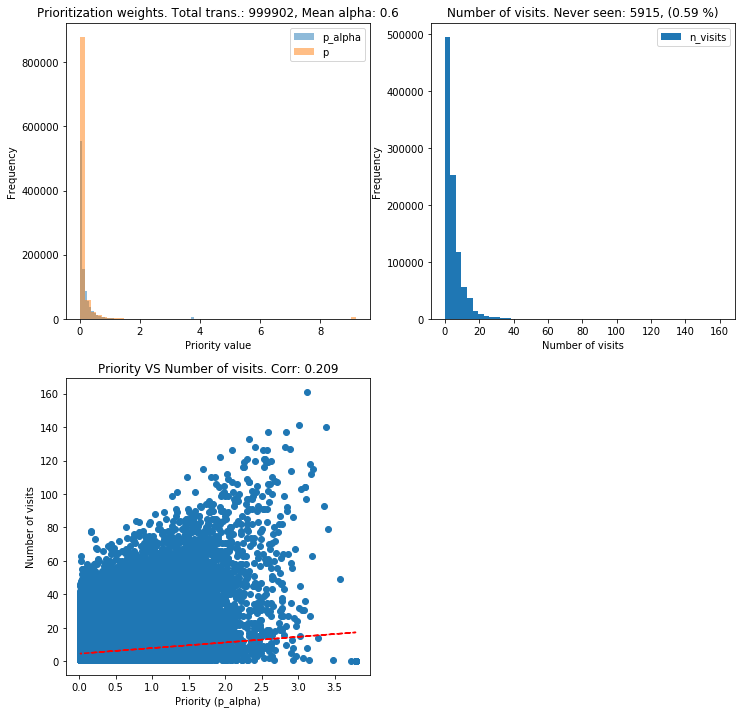

In [20]:
for k, v in replay_buffer.prioritizers.items():
    if k != 'uniform':
        v.plot_priority()

# Plot learning curve

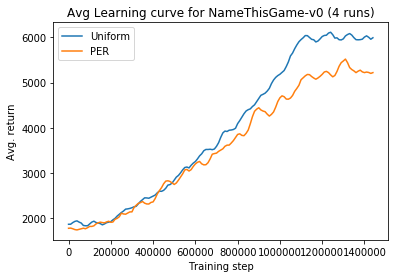

In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

prior_score, vanilla_score = [], []
for k, v in logs_by_run.items():
    if 'prioritized' in k:
        prior_score.append([v_i['average_train_unwr_rews'] for v_i in v])
    else:
        vanilla_score.append([v_i['average_train_unwr_rews'] for v_i in v])
prior_score, vanilla_score = np.array(prior_score), np.array(vanilla_score)
prior_score, vanilla_score = prior_score.mean(axis=0), vanilla_score.mean(axis=0)
prior_score, vanilla_score = moving_average(prior_score, 5), moving_average(vanilla_score, 5)

plt.plot(np.arange(len(vanilla_score))*log_every,
         vanilla_score, label='Uniform')
plt.plot(np.arange(len(prior_score))*log_every,
         prior_score, label='PER')
plt.title(f'Avg Learning curve for {env_name} ({n_experiments} runs)')
plt.legend()
plt.xlabel('Training step')
plt.ylabel('Avg. return')
plt.show()

# Load Models

In [14]:
# Actor
actor = ArgmaxQValue(
        exploration=None
)

# Critic
critic = DQN(
    critic_net=AtariQCNN(in_channels=4, # 1 current frame + 3 recent lags
                         acs_dim=acs_dim),
    device=torch.device('cuda'),
    learning_rate=1e-4,
    batch_size=32,
    gamma=0.99,
    target_updates_freq=10000,
    n_steps_per_update=1,
    update_freq=4,
    double_q=True,
    obs_nlags=3,
    obs_expand_axis=None,
    obs_concat_axis=-1,
    obs_padding='zeros'
)

# Provide actor with critic
actor.set_critic(critic)

# Saving models:
actor.load_checkpoint('trained_models/prioritized_ddqn', 'prioritized_ddqn_NameThisGame-v0_experiment_1_actor')
critic.load_checkpoint('trained_models/prioritized_ddqn', 'prioritized_ddqn_NameThisGame-v0_experiment_1_critic')

Loaded checkpoints for ArgmaxQValue...
global_step
Loaded checkpoints for DQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer scheduler


/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:218: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


# Plot estimated vs actual Q-values

('avg_return', 72.45)
('std_return', 46.18925740905562)
('max_return', 152.0)
('min_return', 8.0)
('mean_pathlen', 449.75)
('n_paths', 20)
('n_transitions', 8995)


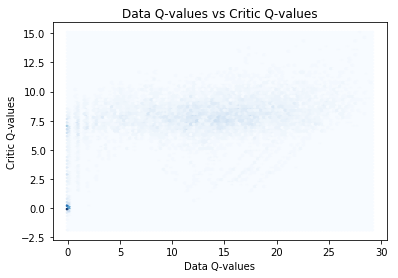

In [16]:
# Crteating environments:
eval_env, _, _ = makeenv(
    env_name=env_name, hcrop=hcrop, 
    hstretch=hstretch, seed=14
)

# Create replay buffer and wrap envs into Sampler:
eval_sampler = Sampler(env=eval_env,
                       obs_nlags=3,
                       obs_expand_axis=None,
                       obs_concat_axis=-1,
                       obs_padding='zeros')

batch = eval_sampler.sample_n_episodes(actor=actor,
                                       n_episodes=20,
                                       max_path_length=None, 
                                       train_sampling=False)

print(*batch.create_logs().items(), sep='\n')

batch.add_disc_cumsum(cumsum_field='q_vals', field='rews', gamma=0.99)
data_q_values = batch.unpack(['q_vals'])

model_q_values = critic.estimate_qvalue(batch)

plt.hexbin(data_q_values, model_q_values, bins=50, cmap=plt.cm.Blues)
plt.title('Data Q-values vs Critic Q-values')
plt.xlabel('Data Q-values')
plt.ylabel('Critic Q-values')
plt.show()

# Visualize trained actor

In [17]:
visualize_actor(env=eval_env, actor=actor, nsteps=1000, train_sampling=False)

Simulation done, total reward: 119.0
Loading video...
